In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(
    "../data/consumption.csv", usecols=["prediction_unit_id", "datetime", "target"]
)[["prediction_unit_id", "datetime", "target"]].rename(
    columns={"prediction_unit_id": "building_id", "target": "consumption"}
)
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,building_id,datetime,consumption
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [3]:
df["consumption"] = df["consumption"].interpolate(method="linear")
df.isna().sum()

building_id    0
datetime       0
consumption    0
dtype: int64

In [33]:
df.to_csv("../data/consumption_no_nan.csv", index=False)

In [35]:
pd.read_csv("../data/consumption_no_nan.csv").isna().sum()

building_id    0
datetime       0
consumption    0
dtype: int64

# Train/Test split

In [4]:
# taking the last 48 hours for test
for i in df["building_id"].unique():
    if i == df["building_id"].unique()[0]:
        df_test = df[df["building_id"]==i][-48:]
        continue
    df_test = pd.concat([df_test, df[df["building_id"]==i][-48:]])
    
df_test.sort_index(inplace=True)
print(df_test.shape)
df_test.head()

(3312, 3)


,building_id,datetime,consumption
906150,26,2023-03-28 00:00:00,5.137
906217,26,2023-03-28 01:00:00,4.212
906284,26,2023-03-28 02:00:00,4.917
906351,26,2023-03-28 03:00:00,4.195
906418,26,2023-03-28 04:00:00,4.518


In [5]:
train_idx = [idx for idx in df.index if idx not in df_test.index]
df_train = df.loc[train_idx]
df_train.shape
df_train.head()

,building_id,datetime,consumption
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [6]:
df.shape[0] == df_train.shape[0] + df_test.shape[0]

True

In [7]:
df.shape[1] == df_train.shape[1] == df_test.shape[1]

True

# Training

In [8]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [9]:
col_params = dict(id_col="building_id", time_col="datetime", target_col="consumption")
col_params

{'id_col': 'building_id', 'time_col': 'datetime', 'target_col': 'consumption'}

In [10]:
import lightgbm as lgb

lgb_params = {
    'verbosity': -1,
    'num_leaves': 512,
}

fcst = MLForecast(
    models={
        'avg': lgb.LGBMRegressor(**lgb_params),
        # 'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
        # 'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq="h",
    target_transforms=[Differences([24])],
    lags=[i+1 for i in range(24)],
    lag_transforms={
        1: [ExpandingMean()],
        24: [RollingMean(window_size=48)],
    },
    date_features=["month", "dayofweek", "hour"],
)

fcst.preprocess(df_train, **col_params).head()

,building_id,datetime,consumption,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag20,lag21,lag22,lag23,lag24,expanding_mean_lag1,rolling_mean_lag24_window_size48,month,dayofweek,hour
5795,0,2021-09-04 23:00:00,-6.630,10.176,-16.948,30.391,7.926,-17.201,-3.185,6.491,...,25.584,8.909,32.118,14.813,19.389,4.519704,5.480750,9,5,23
5796,1,2021-09-04 23:00:00,-0.656,4.648,5.220,-13.346,-10.982,-2.404,-1.357,1.997,...,4.737,4.358,2.976,7.491,7.787,0.645268,0.864937,9,5,23
5797,2,2021-09-04 23:00:00,-35.639,-62.993,5.519,17.114,47.251,-16.126,-23.379,32.545,...,165.606,172.671,151.648,160.884,149.861,33.502592,38.503042,9,5,23
5798,3,2021-09-04 23:00:00,-1.100,-4.200,-3.600,-4.900,-17.900,-16.500,-38.600,-10.800,...,18.500,17.600,17.100,11.700,-1.600,-7.554930,4.497917,9,5,23
5799,4,2021-09-04 23:00:00,-68.429,-83.631,-70.391,-16.480,-11.291,-59.362,-127.090,-178.232,...,76.277,87.274,57.055,13.774,29.268,-38.533958,21.538812,9,5,23


In [11]:
import time

start = time.time()
fcst.fit(df_train, **col_params)
end = time.time()
t = end - start
t

11.405408382415771

# Evaluate

In [12]:
from functools import partial
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mape, mase, mae, rmse

In [13]:
df_eval = pd.merge(df_test, fcst.predict(5), on=["building_id", "datetime"])
daily_mase = partial(mase, seasonality=24)

In [17]:
error = evaluate(
    df_eval, metrics=[mape, daily_mase, mae, rmse], train_df=df_train, **col_params
)
error.drop(columns=["building_id"]).groupby("metric").mean()

,avg
metric,
mae,27.396252
mape,0.148382
mase,0.496212
rmse,31.205136


# Error distribution

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

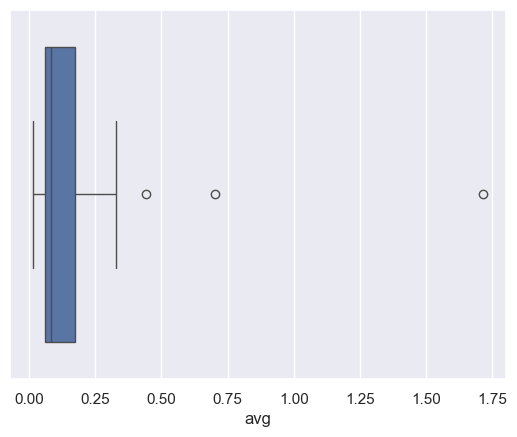

In [48]:
mask = error["metric"] == "mape"
sns.boxplot(x=error.loc[mask, "avg"])
plt.show()

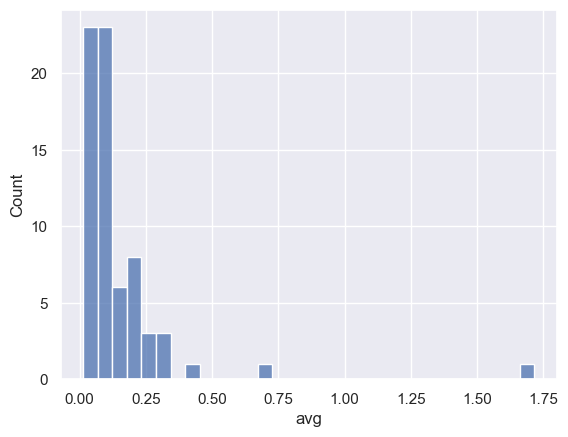

In [49]:
sns.histplot(x=error.loc[mask, "avg"])
plt.show()

# HPO

## Random Search

## Optuna

In [61]:
import optuna

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
)

c:\Users\gabriel.chehade\Documents\Projets\Github\Predict-Energy-Behavior-of-Prosumers-with-Machine-and-Deep-Learning\ML-training\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [62]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
auto_mlf = AutoMLForecast(
    models={'lgb': AutoLightGBM(), 'ridge': AutoRidge()},
    freq="h",
    season_length=24,
)

In [75]:
df_train.columns

Index(['building_id', 'datetime', 'consumption'], dtype='object')

In [76]:
df_train.columns = ["unique_id", "ds", "y"]
df_train.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [77]:
auto_mlf.fit(
    df_train,
    n_windows=2,
    h=24,
    num_samples=2,  # number of trials to run
    # **col_params
)

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'ridge': AutoModel(model=Ridge)})

In [79]:
preds = auto_mlf.predict(24)
preds

,unique_id,ds,lgb,ridge
0,0,2023-05-30 00:00:00,494.575221,509.259315
1,0,2023-05-30 01:00:00,468.728810,490.602879
2,0,2023-05-30 02:00:00,444.330531,473.570450
3,0,2023-05-30 03:00:00,416.076310,457.969369
4,0,2023-05-30 04:00:00,386.457954,443.679554
...,...,...,...,...
1651,68,2023-05-30 19:00:00,11.251472,4.822152
1652,68,2023-05-30 20:00:00,11.530657,4.822265
1653,68,2023-05-30 21:00:00,11.530657,4.821419
1654,68,2023-05-30 22:00:00,11.530657,4.821099
